#### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib. pyplot as plt 
import os
import glob

#### Functions

In [2]:
def import_logfile(filename):
    with open(filename, 'r') as fp:
        lines = fp.readlines()
        return lines

In [3]:
def make_dict(l):
    return {i.split(':')[0].strip(): float(i.split(':')[1]) for i in l}

In [4]:
root_dir = '../log/res_models/'
# dataset = 'amazon-books'
dataset = 'ttrs'
# dataset = 'ml-1m'

In [5]:
folders = glob.glob(f"{root_dir}/{dataset}/*")
models = [f.split('/')[-1] for f in folders]

In [6]:
models

['KGNNLS',
 'ItemKNN',
 'RippleNet',
 'GCMC',
 'DGCF',
 'EASE',
 'KGAT',
 'Pop',
 'MKR',
 'KTUP',
 'LightGCN',
 'CFKG',
 'NGCF',
 'CKE',
 'KGCN',
 'SGL']

In [7]:
metrics = ['recall@', 'precision@', 'mnap@', 'ndcg@']
k = [1, 5, 10, 15, 20]
mcolumns = pd.MultiIndex.from_tuples(list(zip(*[list(np.repeat(metrics, 5)), k * 4])), names=["metrik", "k"])
result_df = pd.DataFrame(columns=pd.MultiIndex.from_tuples([('best_model', 'paths'), ('epochs', 'n')] 
                                                    + list(zip(*[list(np.repeat(metrics, 5)), k * 4])), names=["metrik", "k"]))
result_df

Empty DataFrame
Columns: [(best_model, paths), (epochs, n), (recall@, 1), (recall@, 5), (recall@, 10), (recall@, 15), (recall@, 20), (precision@, 1), (precision@, 5), (precision@, 10), (precision@, 15), (precision@, 20), (mnap@, 1), (mnap@, 5), (mnap@, 10), (mnap@, 15), (mnap@, 20), (ndcg@, 1), (ndcg@, 5), (ndcg@, 10), (ndcg@, 15), (ndcg@, 20)]
Index: []

[0 rows x 22 columns]

In [1]:
for curr_model in models:
    curr_path = sorted(glob.glob(f"{root_dir}/{dataset}/{curr_model}/*.log"))
    if len(curr_path) > 0:
        curr_path = curr_path[-1]#[-1]
        print(curr_model, curr_path)
        curr_logs = import_logfile(curr_path)
        valid_logs = [log for log in curr_logs if any (substring in log for substring in
             ["load_col = {'inter': ", 'Finished training', 'test result: ', 'Loading model structure and parameters from'])]
        if len(valid_logs) == 3:
            n_epochs = 300
            test_metrics = list(dict(eval(valid_logs[-1][valid_logs[-1].find('OrderedDict')+12:-2].strip())).values())
            model_path = valid_logs[-2].split()[-1]
            result_df.loc[curr_model] = [model_path] + [n_epochs] + test_metrics
        if len(valid_logs) == 4:
            n_epochs = int(valid_logs[1].strip().split()[-1])
            model_path = valid_logs[2].split()[-1]
            test_metrics = list(dict(eval(valid_logs[3][valid_logs[3].find('OrderedDict')+12:-2].strip())).values())
            result_df.loc[curr_model] = [model_path] + [n_epochs] + test_metrics
    else:
        print('ELSE', curr_model, curr_path)
        result_df.loc[curr_model] = 0

In [2]:
result_df

In [10]:
models = ['KGNNLS', 'ItemKNN', 'RippleNet', 'GCMC', 'DGCF', 'EASE', 'KGAT',
'MKR', 'KTUP', 'LightGCN', 'CFKG', 'NGCF', 'CKE', 'KGCN', 'SGL', 'Pop']
ttrs_models = ['KGNNLS', 'ItemKNN', 'RippleNet', 'DGCF', 'EASE', 'KGAT',
'MKR', 'KTUP', 'LightGCN', 'CFKG', 'NGCF', 'CKE', 'KGCN', 'SGL', 'Pop']

#### Results

In [100]:
models_groups = {'bipartie': ['EASE', 'GCMC', 'DGCF', 'LightGCN', 'NGCF', 'SGL'],
                 'knowledge': ['EASE', 'KGNNLS', 'RippleNet', 'KGAT', 'MKR', 'KTUP', 'CFKG', 'CKE', 'KGCN']}

In [101]:
print(result_df.shape)
result_df.head(2)

(2, 21)


metrik epochs recall@                                 precision@          \
k           n       1       5      10      15      20          1       5   
DGCF    300.0  0.0299  0.1078  0.1709  0.2205  0.2617     0.3248  0.2480   
Pop     300.0  0.0115  0.0427  0.0715  0.0945  0.1170     0.1538  0.1217   

metrik                  ...   mnap@                                   ndcg@  \
k           10      15  ...       1       5      10      15      20       1   
DGCF    0.2049  0.1819  ...  0.3248  0.1940  0.1570  0.1449  0.1397  0.3248   
Pop     0.1024  0.0910  ...  0.1538  0.0852  0.0645  0.0567  0.0531  0.1538   

metrik                                  
k            5      10      15      20  
DGCF    0.2756  0.2635  0.2654  0.2711  
Pop     0.1335  0.1259  0.1250  0.1273  

[2 rows x 21 columns]

In [52]:
def plot_metrics(models, fname):
    fig = plt.figure(figsize=(25, 6))
    axes = fig.subplots(nrows=1, ncols=4)

    i = 0
    for ax in fig.axes:
        lines_to_plot = result_df.loc[models, (metrics[i])].values
        for n in range(lines_to_plot.shape[0]):
            ax.plot(k, lines_to_plot[n], label=models[n])
        ax.grid()
        ax.set_ylabel(metrics[i], fontsize = 'large')
        ax.set_xlabel('k', fontsize = 'large')
        ax.set_xticks(k)
        i += 1

    lines, labels = fig.axes[-1].get_legend_handles_labels()
        
    fig.legend(lines, labels, loc = 'lower center',
                bbox_to_anchor=(0.5, -0.03), ncol=15, fancybox=True, shadow=True, fontsize = 'large')
    plt.savefig(fname, format='png', bbox_inches='tight')
    plt.show()
    plt.show()
    

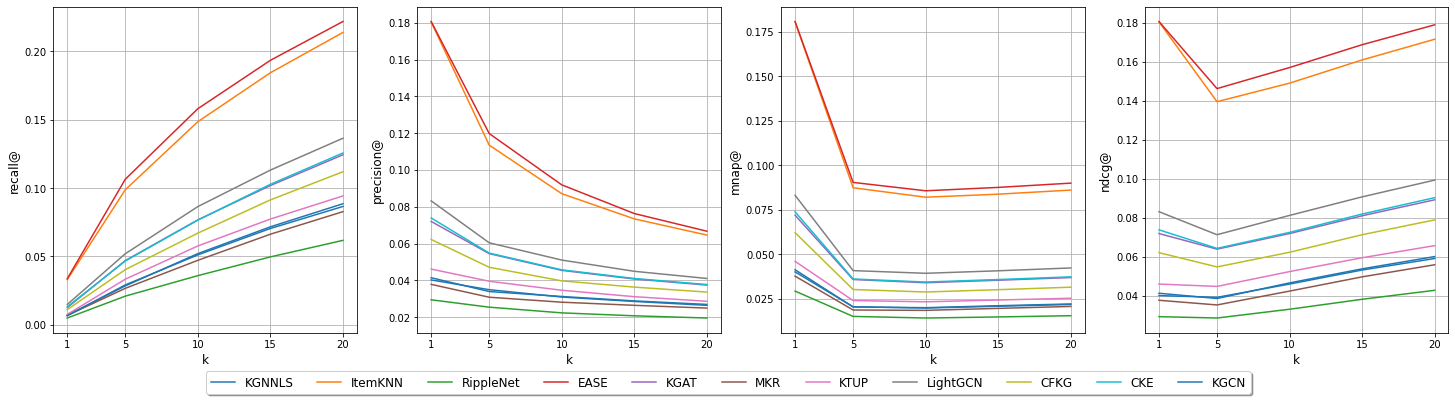

In [33]:
# plot_metrics(list(result_df.index), 'amazon-books-v0.png')